In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
#%gui qt

In [3]:
## Import the custom library
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import dbitx as db

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import json
import seaborn as sns
from tqdm import tqdm
import squidpy as sq
import pandas as pd
import anndata
import imutils
from glob import glob

## Create kidney dataset for ICB collaboration

1. Extract kidney samples
2. Register with high-resolution images
3. Save raw dataset
4. Do preprocessing

In [5]:
file = '/home/jwirth/projects/experiments/37_38/data/aligned_secondimage/37_38_adata_raw_with_images.h5ad'
results_file = '/home/jwirth/projects/experiments/37_38/data/aligned_firstimage/37_38_raw_with_hq_images.h5ad'
preprocessed_file = '/home/jwirth/projects/experiments/37_38/data/aligned_firstimage/37_38_preprocessed_with_hq_images.h5ad'

In [8]:
adata = sc.read(file)

### Exclude alignment images

In [9]:
groups = adata.obs['well_name'].unique()
adata = db.tl.extract_groups(adata, groupby='well_name', groups=groups, uns_exclusion_pattern='align')

### Fetch paths to high-resolution images

In [12]:
well_dict = {
    "A1": "Scene-07",
    "A2": "Scene-08",
    "A3": "Scene-09",
    "B1": "Scene-04",
    "B2": "Scene-05",
    "B3": "Scene-06",
    "C1": "Scene-01",
    "C2": "Scene-02",
    "C3": "Scene-03"
}

channel_dict = {
    "dapi": "c1_",
    "phalloidin": "c2_",
    "bf": "c3ffc_"
}

In [13]:
template_list = glob("/home/jwirth/projects/experiments/37_38/data/image_registration/reg_images/stitched/*.tif")

In [14]:
# create dictionary with paths to the high-resolution images
image_dir_dict = {}

for well in well_dict:
    pattern = well_dict[well]
    files_well = [elem for elem in template_list if pattern in elem]
    for ch in channel_dict:
        pattern = channel_dict[ch]
        image_dir_dict["{}_{}".format(well, ch)] = [elem for elem in files_well if pattern in elem][0]

In [16]:
adata_trans = db.im.register_adata_coords_to_new_images(adata, groupby='well_name', image_dir_dict=image_dir_dict, 
                                          reg_channel='dapi', in_place=False, debug=False)

2021-09-10 14:53:10: Process group A1...
2021-09-10 14:53:11: Load image for key A1_bf...
2021-09-10 14:54:30: Load image for key A1_dapi...
2021-09-10 14:55:37: Load image for key A1_phalloidin...
2021-09-10 14:56:41: Register image A1_dapi...
Convert image to grayscale...
2021-09-10 14:56:41: Get features...
     Method: SIFT...
2021-09-10 14:58:40: Compute matches...
2021-09-10 14:58:45: Filter matches...
2021-09-10 14:58:45: Fetch keypoints...
2021-09-10 14:58:45: Compute homogaphy matrix...
2021-09-10 14:58:45: Register image...
2021-09-10 14:58:45: Transform coordinates...
2021-09-10 14:58:45: Recalculate scale...
2021-09-10 14:58:46: Rotate image A1_bf by 1.3657850012831387 degrees...
2021-09-10 14:58:47: Rotate image A1_dapi by 1.3657850012831387 degrees...
2021-09-10 14:58:49: Rotate image A1_phalloidin by 1.3657850012831387 degrees...
2021-09-10 14:58:50: Rotate coordinates of group A1 by 1.3657850012831387 degrees...
2021-09-10 14:58:50: Store images and coordinates of group

2021-09-10 15:56:35: Load image for key C3_bf...
2021-09-10 15:58:27: Load image for key C3_dapi...
2021-09-10 16:00:10: Load image for key C3_phalloidin...
2021-09-10 16:02:01: Register image C3_dapi...
Convert image to grayscale...
2021-09-10 16:02:01: Get features...
     Method: SIFT...
2021-09-10 16:04:26: Compute matches...
2021-09-10 16:04:32: Filter matches...
2021-09-10 16:04:32: Fetch keypoints...
2021-09-10 16:04:32: Compute homogaphy matrix...
2021-09-10 16:04:32: Register image...
2021-09-10 16:04:33: Transform coordinates...
2021-09-10 16:04:33: Recalculate scale...
2021-09-10 16:04:33: Rotate image C3_bf by 6.285483402711675 degrees...
2021-09-10 16:04:35: Rotate image C3_dapi by 6.285483402711675 degrees...
2021-09-10 16:04:37: Rotate image C3_phalloidin by 6.285483402711675 degrees...
2021-09-10 16:04:39: Rotate coordinates of group C3 by 6.285483402711675 degrees...
2021-09-10 16:04:39: Store images and coordinates of group C3 in anndata object...


## Save raw dataset before checking

In [23]:
adata_trans.write(results_file)

In [6]:
adata_trans = sc.read(results_file)

### Check quality of registration

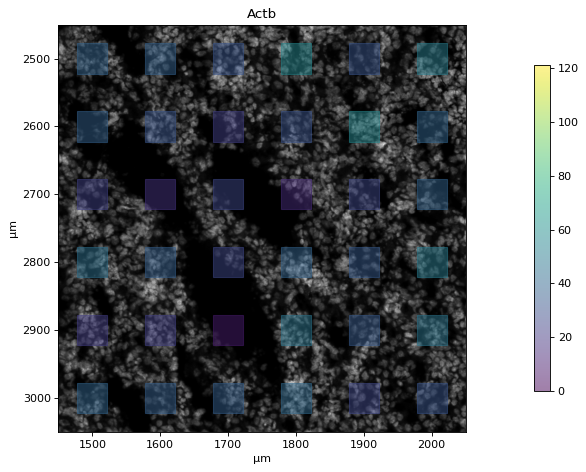

In [20]:
db.pl.spatial(adata, keys=['Actb'], groupby='well_name', group='B3', image_key='dapi', lowres=False,
              xlim=(1500,2000), ylim=(2500,3000), alpha=0.5)

In [28]:
db.pl.spatial(adata, keys=['Actb'], groupby='well_name', group=['B3', 'C1'], image_key='dapi', lowres=False,
              xlim=(1500,2000), ylim=(2500,3000), alpha=0.5)

TypeError: 'in <string>' requires string as left operand, not list

# !!Fix error to plot here multiple groups at once!!

### Scale down images and save under `lowres` to make plotting faster

In [19]:
db.im.resize_images_in_adata(adata_trans, scale_factor=0.2)

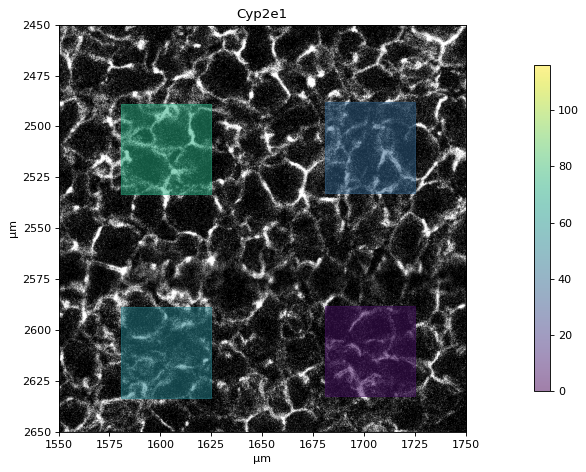

In [33]:
db.pl.spatial(adata_trans, keys=['Cyp2e1'], groupby='well_name', group='B2', image_key='phalloidin', lowres=False,
              xlim=(1600,1700), ylim=(2500,2600), alpha=0.5,
              histogram_setting=(0,5)
             )

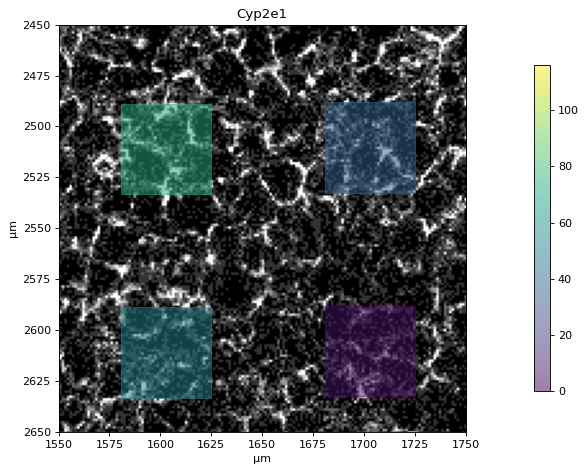

In [32]:
db.pl.spatial(adata_trans, keys=['Cyp2e1'], groupby='well_name', group='B2', image_key='phalloidin', lowres=True,
              xlim=(1600,1700), ylim=(2500,2600), alpha=0.5,
              histogram_setting=(0,5)
             )

## Save scaled-down before checking

In [35]:
adata_trans.write(results_file)